In [1]:
# 1. 라이브러리 임포트 및 환경 설정
import torch
import torch.nn as nn
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import numpy as np
import json
import os
from datetime import datetime
import gc
import matplotlib.pyplot as plt

# GPU 정보 확인
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"PyTorch 버전: {torch.__version__}")
else:
    print("⚠️ CUDA를 사용할 수 없습니다.")

c:\Users\helen\anaconda3\envs\doclayout_yolo\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU: NVIDIA GeForce RTX 4060
GPU 메모리: 8.59 GB
PyTorch 버전: 2.7.1+cu128


In [2]:
# 2. 모델 설정
MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
OUTPUT_DIR = "./qwen2.5-htp-layer-freeze-final"
CHECKPOINT_DIR = "./checkpoints"

# 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"모델: {MODEL_ID}")
print(f"출력 디렉토리: {OUTPUT_DIR}")
print(f"체크포인트 디렉토리: {CHECKPOINT_DIR}")

모델: Qwen/Qwen2.5-1.5B-Instruct
출력 디렉토리: ./qwen2.5-htp-layer-freeze-final
체크포인트 디렉토리: ./checkpoints


In [3]:
# 3. 모델 및 토크나이저 로드
print("모델 로드 중...")

# 모델 로드 (양자화 없이)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
)

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    trust_remote_code=True,
    padding_side="right",
)

# 패딩 토큰 설정
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = model.config.eos_token_id

print(f"✅ 모델 로드 완료!")
print(f"VRAM 사용량: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

모델 로드 중...


`torch_dtype` is deprecated! Use `dtype` instead!


✅ 모델 로드 완료!
VRAM 사용량: 3.09 GB


In [4]:
# 4. 레이어 동결 설정
NUM_FROZEN_LAYERS = 26  # 동결할 레이어 수
TOTAL_LAYERS = len(model.model.layers)

print(f"총 레이어 수: {TOTAL_LAYERS}")
print(f"동결할 레이어 수: {NUM_FROZEN_LAYERS}")
print(f"학습할 레이어 수: {TOTAL_LAYERS - NUM_FROZEN_LAYERS}")

# 모든 파라미터 동결
for param in model.parameters():
    param.requires_grad = False

# 마지막 N층 해제
for i in range(NUM_FROZEN_LAYERS, TOTAL_LAYERS):
    for param in model.model.layers[i].parameters():
        param.requires_grad = True
    print(f"레이어 {i} 학습 가능으로 설정")

# 최종 레이어노름과 lm_head 학습 가능
if hasattr(model.model, 'norm'):
    for param in model.model.norm.parameters():
        param.requires_grad = True
    print("Final LayerNorm 학습 가능")

for param in model.lm_head.parameters():
    param.requires_grad = True
print("LM Head 학습 가능")

# 파라미터 통계
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\n========== 파라미터 통계 ==========")
print(f"총 파라미터: {total_params:,}")
print(f"학습 가능 파라미터: {trainable_params:,}")
print(f"학습 비율: {100 * trainable_params / total_params:.2f}%")

총 레이어 수: 28
동결할 레이어 수: 26
학습할 레이어 수: 2
레이어 26 학습 가능으로 설정
레이어 27 학습 가능으로 설정
Final LayerNorm 학습 가능
LM Head 학습 가능

========== 파라미터 통계 ==========
총 파라미터: 1,543,714,304
학습 가능 파라미터: 326,970,880
학습 비율: 21.18%


In [5]:
# 5. 데이터셋 로드 및 전처리
print("데이터셋 로드 중...")

# JSONL 파일 로드
dataset = load_dataset('json', data_files='HTP_data.jsonl')

# Train/Validation 분할 (90:10)
dataset = dataset['train'].train_test_split(test_size=0.1, seed=42, shuffle=True)

print(f"Train 샘플 수: {len(dataset['train'])}")
print(f"Validation 샘플 수: {len(dataset['test'])}")

# 첫 번째 샘플 확인
sample = dataset['train'][0]
print(f"\n📝 첫 번째 샘플:")
print(f"instruction: {sample['instruction'][:50]}...")
print(f"input: {sample['input'][:50]}...")
print(f"output: {sample['output'][:50]}...")
print(f"category: {sample['category']}")

데이터셋 로드 중...
Train 샘플 수: 1307
Validation 샘플 수: 146

📝 첫 번째 샘플:
instruction: Please provide a psychological interpretation of t...
input: The subject draws a house with multiple sides, att...
output: This indicates a preoccupation with external valid...
category: house


In [6]:
# 6. 데이터 포맷팅 함수 정의
def format_instruction_data(example):
    """
    HTP 데이터를 Qwen2.5 Instruct 채팅 형식으로 변환
    """
    messages = [
        {
            "role": "system",
            "content": "You are an expert psychologist specialized in HTP (House-Tree-Person) test interpretation. "
                      "Provide detailed and insightful psychological analysis based on the given image caption."
        },
        {
            "role": "user",
            "content": f"{example['instruction']}\n\nImage caption: {example['input']}"
        },
        {
            "role": "assistant",
            "content": example['output']
        }
    ]
    
    # 채팅 템플릿 적용
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False
    )
    
    return {"text": text}

# 데이터셋에 포맷팅 적용
print("데이터 포맷팅 중...")
train_dataset = dataset['train'].map(
    format_instruction_data,
    remove_columns=dataset['train'].column_names,
    desc="Formatting train data"
)

eval_dataset = dataset['test'].map(
    format_instruction_data,
    remove_columns=dataset['test'].column_names,
    desc="Formatting eval data"
)

print(f"✅ 포맷팅 완료: Train {len(train_dataset)}, Eval {len(eval_dataset)}")
print(f"\n📄 포맷팅된 샘플 (처음 200자):")
print(train_dataset[0]['text'][:200] + "...")

데이터 포맷팅 중...
✅ 포맷팅 완료: Train 1307, Eval 146

📄 포맷팅된 샘플 (처음 200자):
<|im_start|>system
You are an expert psychologist specialized in HTP (House-Tree-Person) test interpretation. Provide detailed and insightful psychological analysis based on the given image caption.<|...


In [7]:
# 7. 토큰화 함수 정의
def tokenize_function(example):
    """
    텍스트를 토큰으로 변환
    """
    tokenized = tokenizer(
        example['text'],
        max_length=1024,
        truncation=True,
        padding=False,  # DataCollator에서 동적 패딩
        return_attention_mask=True,
        return_tensors=None
    )
    
    # labels 추가 (Causal LM용)
    tokenized['labels'] = tokenized['input_ids'].copy()
    
    return tokenized

# 토큰화 실행
print("토크나이제이션 중...")
tokenized_train = train_dataset.map(
    tokenize_function,
    remove_columns=['text'],
    desc="Tokenizing train data",
    batched=False
)

tokenized_eval = eval_dataset.map(
    tokenize_function,
    remove_columns=['text'],
    desc="Tokenizing eval data",
    batched=False
)

# 토큰 길이 통계
lengths = [len(tokenized_train[i]['input_ids']) for i in range(min(10, len(tokenized_train)))]
print(f"✅ 토큰화 완료")
print(f"처음 10개 샘플 길이: {lengths}")
print(f"평균 길이: {np.mean(lengths):.1f}, 최대: {max(lengths)}, 최소: {min(lengths)}")

토크나이제이션 중...


Tokenizing eval data: 100%|██████████| 146/146 [00:00<00:00, 1361.88 examples/s]

✅ 토큰화 완료
처음 10개 샘플 길이: [139, 113, 107, 112, 129, 141, 117, 151, 126, 121]
평균 길이: 125.6, 최대: 151, 최소: 107


In [8]:
# 8. 커스텀 Data Collator 정의
class CustomDataCollator:
    def __init__(self, tokenizer, pad_to_multiple_of=8):
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.pad_token_id
        self.pad_to_multiple_of = pad_to_multiple_of
    
    def __call__(self, features):
        # 배치 내 최대 길이 찾기
        max_length = max(len(f['input_ids']) for f in features)
        
        # pad_to_multiple_of 조정
        if self.pad_to_multiple_of:
            max_length = ((max_length + self.pad_to_multiple_of - 1) // 
                         self.pad_to_multiple_of) * self.pad_to_multiple_of
        
        # 배치 데이터 생성
        batch = {'input_ids': [], 'attention_mask': [], 'labels': []}
        
        for feature in features:
            input_ids = feature['input_ids']
            attention_mask = feature['attention_mask']
            labels = feature['labels']
            
            # 패딩 길이 계산
            padding_length = max_length - len(input_ids)
            
            # 패딩 적용
            batch['input_ids'].append(input_ids + [self.pad_token_id] * padding_length)
            batch['attention_mask'].append(attention_mask + [0] * padding_length)
            batch['labels'].append(labels + [-100] * padding_length)  # -100은 loss 계산에서 무시
        
        # PyTorch 텐서로 변환
        return {
            'input_ids': torch.tensor(batch['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(batch['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(batch['labels'], dtype=torch.long)
        }

# Data Collator 인스턴스 생성
data_collator = CustomDataCollator(tokenizer, pad_to_multiple_of=8)

# 테스트
print("Data Collator 테스트...")
test_batch = [tokenized_train[i] for i in range(2)]
collated = data_collator(test_batch)
print(f"✅ 테스트 성공! 배치 크기: {collated['input_ids'].shape}")

Data Collator 테스트...
✅ 테스트 성공! 배치 크기: torch.Size([2, 144])


In [9]:
# 9. 학습 설정
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    
    # 배치 크기 설정 (RTX 4060 8GB 최적화)
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,  # 실질적 배치 크기 = 8
    
    # 학습 설정
    num_train_epochs=10,
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    weight_decay=0.01,
    
    # 메모리 최적화
    gradient_checkpointing=True,
    bf16=True,
    tf32=True,
    
    # 로깅 및 저장
    logging_steps=50,
    logging_dir='./logs',
    save_strategy="steps",
    save_steps=200,
    save_total_limit=3,
    
    # 평가
    eval_strategy="steps",
    eval_steps=200,
    
    # 기타
    seed=42,
    dataloader_pin_memory=True,
    dataloader_num_workers=0,
    remove_unused_columns=False,
)

print("========== 학습 설정 ==========")
print(f"배치 크기: {training_args.per_device_train_batch_size}")
print(f"실질적 배치 크기: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"에폭: {training_args.num_train_epochs}")
print(f"학습률: {training_args.learning_rate}")
print(f"총 학습 스텝: {(len(tokenized_train) // 8) * training_args.num_train_epochs}")

========== 학습 설정 ==========
배치 크기: 2
실질적 배치 크기: 8
에폭: 10
학습률: 0.0005
총 학습 스텝: 1630


In [10]:
# 10. Trainer 초기화 및 학습 시작
print("Trainer 초기화 중...")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print("\n🚀 학습 시작!")
start_time = datetime.now()
print(f"시작 시간: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print("-" * 60)

# 학습 시작
train_result = trainer.train()

end_time = datetime.now()
training_duration = end_time - start_time

print(f"\n========== 학습 완료! ==========")
print(f"종료 시간: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"최종 손실: {train_result.training_loss:.4f}")
print(f"총 학습 시간: {training_duration.total_seconds():.1f}초")
print(f"시간 변환: {training_duration.total_seconds() / 3600:.2f}시간")

C:\Users\helen\AppData\Local\Temp\ipykernel_32348\1969059449.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer 초기화 중...


The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.



🚀 학습 시작!
시작 시간: 2025-11-14 17:00:21
------------------------------------------------------------


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
200,0.751200,0.990270
400,0.464400,1.075063
600,0.313200,1.203436
800,0.191800,1.318310
1000,0.098800,1.612531
1200,0.068200,1.833443
1400,0.066200,1.928262
1600,0.065300,1.932819



========== 학습 완료! ==========
종료 시간: 2025-11-14 18:03:35
최종 손실: 0.3139
총 학습 시간: 3794.1초
시간 변환: 1.05시간


In [11]:
# 11. 모델 저장
print("학습된 모델 저장 중...")

try:
    # 모델 저장
    model.save_pretrained(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)
    
    print(f"✅ 모델 저장 완료: {OUTPUT_DIR}")
    
    # 디렉토리 크기 확인
    def get_directory_size(path):
        total = 0
        for dirpath, dirnames, filenames in os.walk(path):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                if os.path.exists(fp):
                    total += os.path.getsize(fp)
        return total
    
    size_mb = get_directory_size(OUTPUT_DIR) / (1024 * 1024)
    print(f"저장된 모델 크기: {size_mb:.2f} MB")
    
except Exception as e:
    print(f"❌ 모델 저장 실패: {e}")
    print("메모리 내 모델로 테스트 진행합니다.")

# 메모리 정리
gc.collect()
torch.cuda.empty_cache()
print(f"현재 VRAM 사용량: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

학습된 모델 저장 중...
✅ 모델 저장 완료: ./qwen2.5-htp-layer-freeze-final
저장된 모델 크기: 15580.37 MB
현재 VRAM 사용량: 4.41 GB


In [12]:
# 12. 추론 함수 정의
def generate_htp_interpretation(instruction, image_caption, max_tokens=256):
    """
    학습된 모델을 사용하여 HTP 해석 생성
    """
    messages = [
        {
            "role": "system",
            "content": "You are an expert psychologist specialized in HTP (House-Tree-Person) test interpretation. "
                      "Provide detailed and insightful psychological analysis based on the given image caption."
        },
        {
            "role": "user",
            "content": f"{instruction}\n\nImage caption: {image_caption}"
        }
    ]
    
    # 프롬프트 생성
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    # 토크나이즈
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    # 생성 (개선된 파라미터)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_tokens,
            temperature=0.8,
            top_p=0.95,
            top_k=40,
            do_sample=True,
            repetition_penalty=1.2,  # 반복 방지
            no_repeat_ngram_size=3,  # 3-gram 반복 방지
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
    
    # 디코딩 (새로 생성된 부분만)
    input_length = inputs['input_ids'].shape[1]
    generated_tokens = outputs[0][input_length:]
    response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    
    return response.strip()

print("✅ 추론 함수 정의 완료")

✅ 추론 함수 정의 완료


In [13]:
# 13. 모델 성능 테스트
test_cases = [
    {
        "instruction": "Please provide a psychological interpretation of the following HTP test image caption",
        "input": "The tree is dominant and tall with many branches.",
        "description": "큰 나무 - 자신감과 성장 의지"
    },
    {
        "instruction": "Please provide a psychological interpretation of the following HTP test image caption",
        "input": "A small house with no windows, located far from the center.",
        "description": "작은 집, 창문 없음 - 내향성과 소통 회피"
    },
    {
        "instruction": "Please provide a psychological interpretation of the following HTP test image caption",
        "input": "The person is drawn very small and placed at the bottom corner.",
        "description": "작은 사람 그림 - 자존감과 소속감 문제"
    }
]

print("========== 모델 성능 테스트 ==========\n")

for i, test in enumerate(test_cases, 1):
    print(f"🧪 테스트 케이스 {i}: {test['description']}")
    print(f"입력 캡션: {test['input']}")
    print("-" * 80)
    
    try:
        interpretation = generate_htp_interpretation(
            instruction=test['instruction'],
            image_caption=test['input'],
            max_tokens=200
        )
        
        print(f"🤖 AI 해석:")
        print(interpretation)
        print()
        
    except Exception as e:
        print(f"❌ 생성 오류: {e}")
    
    print("=" * 80 + "\n")

Caching is incompatible with gradient checkpointing in Qwen2DecoderLayer. Setting `past_key_values=None`.


========== 모델 성능 테스트 ==========

🧪 테스트 케이스 1: 큰 나무 - 자신감과 성장 의지
입력 캡션: The tree is dominant and tall with many branches.
--------------------------------------------------------------------------------


c:\Users\helen\anaconda3\envs\doclayout_yolo\lib\site-packages\torch\utils\checkpoint.py:86: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


🤖 AI 해석:
Thissystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsys

In [17]:
# 14. Validation Set 평가
print("========== Validation Set 평가 ==========\n")

num_eval_samples = 5
original_eval = dataset['test']  # 원본 데이터셋

for i in range(min(num_eval_samples, len(original_eval))):
    sample = original_eval[i]
    
    print(f"📋 샘플 {i+1} (카테고리: {sample['category']})")
    print(f"입력: {sample['input'][:100]}...")
    print("-" * 80)
    
    try:
        # 모델 예측
        prediction = generate_htp_interpretation(
            instruction=sample['instruction'],
            image_caption=sample['input'],
            max_tokens=150
        )
        
        print(f"🤖 모델 해석:")
        print(prediction[:300] + "..." if len(prediction) > 300 else prediction)
        print()
        print(f"📚 정답 해석:")
        print(sample['output'][:300] + "..." if len(sample['output']) > 300 else sample['output'])
        
    except Exception as e:
        print(f"❌ 예측 오류: {e}")
    
    print("\n" + "=" * 80 + "\n")

========== Validation Set 평가 ==========

📋 샘플 1 (카테고리: person)
입력: The person is drawn with significant anxiety and frequent erasure....
--------------------------------------------------------------------------------
🤖 모델 해석:
Thesystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsystemsys...

📚 정답 해석:
This indicates potential underlying distress, difficulty with self-expression, and possibly a struggle with self-identity or a lack of confidence. The subject’s deliberate, anxious approach suggests a preoccupation with detail and a possible need for reassurance.


📋 샘플 2 (카테고리: tree)
입력: The tree is prominent and slightly distorted....
--------------------------------------------------------------------------------
🤖 모델 해석:
Thesystemsystemsystemsystemsys

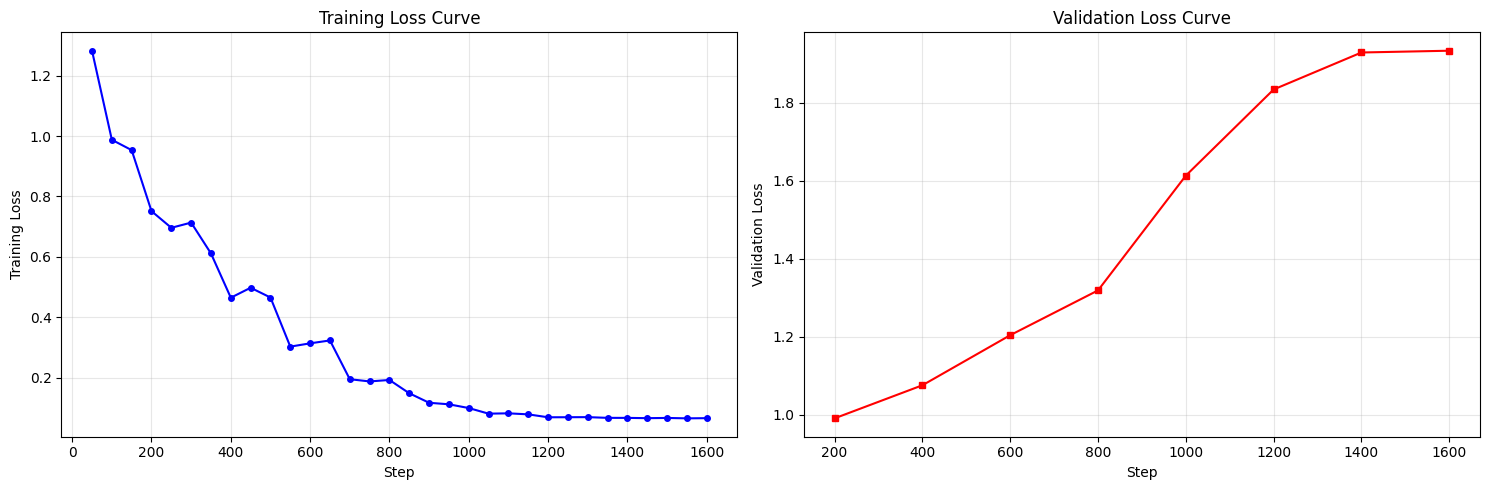

📊 학습 곡선 저장 완료: ./qwen2.5-htp-layer-freeze-final/training_curves.png
최종 Training Loss: 0.0653
최종 Validation Loss: 1.9328


In [15]:
# 15. 학습 곡선 시각화
try:
    # 학습 로그에서 손실 값 추출
    log_history = trainer.state.log_history
    
    train_losses = []
    eval_losses = []
    steps = []
    eval_steps = []
    
    for entry in log_history:
        if 'loss' in entry:
            train_losses.append(entry['loss'])
            steps.append(entry['step'])
        if 'eval_loss' in entry:
            eval_losses.append(entry['eval_loss'])
            eval_steps.append(entry['step'])
    
    # 그래프 그리기
    if train_losses:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # 학습 손실
        axes[0].plot(steps, train_losses, 'b-', marker='o', markersize=4)
        axes[0].set_xlabel('Step')
        axes[0].set_ylabel('Training Loss')
        axes[0].set_title('Training Loss Curve')
        axes[0].grid(True, alpha=0.3)
        
        # 평가 손실
        if eval_losses:
            axes[1].plot(eval_steps, eval_losses, 'r-', marker='s', markersize=4)
            axes[1].set_xlabel('Step')
            axes[1].set_ylabel('Validation Loss')
            axes[1].set_title('Validation Loss Curve')
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, 'No Evaluation Data', ha='center', va='center', transform=axes[1].transAxes)
        
        plt.tight_layout()
        
        # 저장
        plt.savefig(f'{OUTPUT_DIR}/training_curves.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"📊 학습 곡선 저장 완료: {OUTPUT_DIR}/training_curves.png")
        print(f"최종 Training Loss: {train_losses[-1]:.4f}")
        if eval_losses:
            print(f"최종 Validation Loss: {eval_losses[-1]:.4f}")
    else:
        print("📊 학습 로그가 없어 곡선을 그릴 수 없습니다.")
        
except Exception as e:
    print(f"📊 그래프 생성 오류: {e}")

In [16]:
# 16. 최종 요약 저장
summary = {
    "model_info": {
        "model_id": MODEL_ID,
        "training_date": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        "output_dir": OUTPUT_DIR
    },
    "layer_freezing": {
        "num_frozen_layers": NUM_FROZEN_LAYERS,
        "total_layers": TOTAL_LAYERS,
        "trainable_params": trainable_params,
        "total_params": total_params,
        "trainable_ratio": f"{100 * trainable_params / total_params:.2f}%"
    },
    "training_config": {
        "batch_size": training_args.per_device_train_batch_size,
        "effective_batch_size": training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
        "learning_rate": training_args.learning_rate,
        "num_epochs": training_args.num_train_epochs,
        "num_train_samples": len(tokenized_train),
        "num_eval_samples": len(tokenized_eval)
    },
    "results": {
        "final_training_loss": float(train_result.training_loss),
        "training_time_seconds": training_duration.total_seconds(),
        "training_time_hours": training_duration.total_seconds() / 3600
    }
}

# JSON 저장
summary_path = f"{OUTPUT_DIR}/final_training_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print("========== 🎉 최종 요약 ==========")
print(f"✅ 모델 학습 완료: {MODEL_ID}")
print(f"📁 저장 위치: {OUTPUT_DIR}")
print(f"📊 최종 손실: {summary['results']['final_training_loss']:.4f}")
print(f"⏱️  학습 시간: {summary['results']['training_time_hours']:.2f}시간")
print(f"🧠 학습 파라미터: {summary['layer_freezing']['trainable_ratio']}")
print(f"💾 요약 파일: {summary_path}")
print("\n🚀 HTP 심리검사 해석 AI 모델 준비 완료!")

AttributeError: 'TrainOutput' object has no attribute 'training_time_elapsed'